In [ ]:
####  1. AKU ADALAH SURYA RAJA PENGHITAMAN

In [10]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

print('Python', os.sys.version)

Python 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [ ]:
# Load data
PATH = '/kaggle/input/bitcoin-historical-data/btcusd_1-min_data.csv'  # path provided in the environment
SAMPLE_N = 200000  # use last N rows; ubah sesuai RAM Anda

df = pd.read_csv(PATH)
print('Total rows in file:', len(df))

# sort by Timestamp if needed and take last SAMPLE_N rows
df = df.sort_values('Timestamp').reset_index(drop=True)
if SAMPLE_N and len(df) > SAMPLE_N:
    df = df.iloc[-SAMPLE_N:].reset_index(drop=True)
print('Using rows:', len(df))
df.head()


Total rows in file: 7296158
Using rows: 200000


,Timestamp,Open,High,Low,Close,Volume
0,1.751251e+09,108560.0,108572.0,108560.0,108572.0,0.026070
1,1.751251e+09,108572.0,108583.0,108572.0,108583.0,0.063894
2,1.751251e+09,108581.0,108582.0,108581.0,108581.0,0.002710
3,1.751251e+09,108581.0,108582.0,108581.0,108581.0,0.116414
4,1.751251e+09,108598.0,108600.0,108593.0,108600.0,0.070940


In [12]:
# Feature engineering
df['dt'] = pd.to_datetime(df['Timestamp'], unit='s', origin='unix')
df.set_index('dt', inplace=True)

# Basic features
df['return_1'] = df['Close'].pct_change(1).fillna(0) # TARGET BARU
df['lag1'] = df['Close'].shift(1).fillna(method='bfill')
df['lag2'] = df['Close'].shift(2).fillna(method='bfill')
df['rolling_5_mean'] = df['Close'].rolling(window=5, min_periods=1).mean()
df['rolling_15_mean'] = df['Close'].rolling(window=15, min_periods=1).mean()
df['rolling_60_mean'] = df['Close'].rolling(window=60, min_periods=1).mean()

# Time features
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df = df.drop(columns=['Timestamp'], errors='ignore')

df = df.dropna().reset_index(drop=True)

In [13]:
# Split data
FEATURES = ['Open','High','Low','Volume','lag1','lag2','rolling_5_mean','rolling_15_mean','rolling_60_mean','hour','minute']
TARGET = 'return_1' # Target diubah menjadi return_1

X = df[FEATURES]
y = df[TARGET]

# Simpan data Close untuk konversi prediksi return kembali ke harga
y_actual_price = df['Close'].copy()
X_with_close = df[['Close'] + FEATURES].copy()

# time-aware split: keep last 20% for test
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Split data harga untuk evaluasi
y_price_test = y_actual_price.iloc[split_idx:]
X_test_with_close = X_with_close.iloc[split_idx:]

In [14]:
#Evaluation Functions
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid division by zero: add small epsilon
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape_v = mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE (%)': mape_v, 'R2': r2}


In [15]:
# Train XGBoost
from xgboost import XGBRegressor

# Gunakan parameter yang sama dengan sebelumnya
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Prediksi return
y_pred_return_xgb = xgb_model.predict(X_test)

# Konversi prediksi return ke prediksi harga Close
# Prediksi Harga = Harga_Lag1 * (1 + Prediksi_Return)
# Karena lag1 sudah ada di FEATURES/X_test, kita ambil dari situ
y_pred_price_xgb = X_test['lag1'] * (1 + y_pred_return_xgb)

# Evaluasi menggunakan harga aktual (bukan return)
# Nilai metrik (MAE, RMSE, MAPE) yang lebih rendah menunjukkan kinerja yang lebih baik.
res_xgb = evaluate(y_price_test, y_pred_price_xgb)
print('XGBoost evaluation (Predicting Price from Return):')
for k,v in res_xgb.items():
    print(f"{k}: {v:.6f}")
    
# Save model (opsional)
joblib.dump(xgb_model, 'xgb_return_model.joblib')

[0]	validation_0-rmse:0.00064
[1]	validation_0-rmse:0.00064
[2]	validation_0-rmse:0.00064
[3]	validation_0-rmse:0.00064
[4]	validation_0-rmse:0.00064
[5]	validation_0-rmse:0.00064
[6]	validation_0-rmse:0.00064
[7]	validation_0-rmse:0.00064
[8]	validation_0-rmse:0.00064
[9]	validation_0-rmse:0.00064
[10]	validation_0-rmse:0.00064
[11]	validation_0-rmse:0.00064
[12]	validation_0-rmse:0.00064
[13]	validation_0-rmse:0.00064
[14]	validation_0-rmse:0.00064
[15]	validation_0-rmse:0.00064
[16]	validation_0-rmse:0.00064
[17]	validation_0-rmse:0.00064
[18]	validation_0-rmse:0.00064
[19]	validation_0-rmse:0.00064
[20]	validation_0-rmse:0.00064
[21]	validation_0-rmse:0.00064
[22]	validation_0-rmse:0.00064
[23]	validation_0-rmse:0.00064
[24]	validation_0-rmse:0.00064
[25]	validation_0-rmse:0.00064
[26]	validation_0-rmse:0.00064
[27]	validation_0-rmse:0.00064
[28]	validation_0-rmse:0.00064
[29]	validation_0-rmse:0.00064
[30]	validation_0-rmse:0.00064
[31]	validation_0-rmse:0.00064
[32]	validation_0-

['xgb_return_model.joblib']

In [16]:
# Train LightGBM
import lightgbm as lgb
lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=8, random_state=42, n_jobs=-1)
# Hapus early_stopping_rounds dan verbose untuk mengatasi TypeError pada LightGBM versi baru
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

y_pred_lgb = lgb_model.predict(X_test)
res_lgb = evaluate(y_test, y_pred_lgb)
print('LightGBM evaluation:')
for k,v in res_lgb.items():
    print(f"{k}: {v:.6f}")

# save
joblib.dump(lgb_model, 'lgb_model.joblib')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 11
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM evaluation:
MAE: 0.000386
MSE: 0.000000
RMSE: 0.000592
MAPE (%): 8387.460584
R2: 0.147319


['lgb_model.joblib']

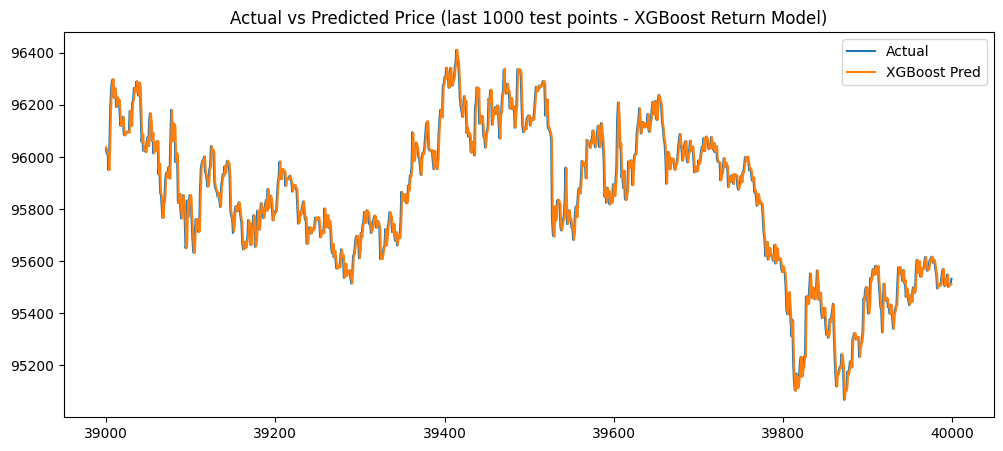

,actual,xgb_pred_price
0,95521.0,95569.857590
1,95504.0,95520.857663
2,95523.0,95505.616665
3,95533.0,95523.546587
4,95549.0,95534.093288
5,95501.0,95548.515911
6,95508.0,95500.857692
7,95508.0,95509.001919
8,95511.0,95507.857682
9,95532.0,95513.026672


In [17]:
# Plot a sample of predictions vs actuals for last 1000 test points
N = 1000
idx = np.arange(len(y_price_test))[-N:]

plt.figure(figsize=(12,5))
plt.plot(idx, y_price_test.values[-N:], label='Actual')
plt.plot(idx, y_pred_price_xgb.values[-N:], label='XGBoost Pred') # Pastikan menggunakan .values jika y_pred_price_xgb adalah Series
plt.legend()
plt.title('Actual vs Predicted Price (last {} test points - XGBoost Return Model)'.format(N))
plt.show()

# show head of predictions
pd.DataFrame({'actual': y_price_test.values[-10:], 'xgb_pred_price': y_pred_price_xgb.values[-10:]})

In [18]:
# Save evaluation summary
summary = pd.DataFrame([res_xgb, res_lgb], index=['XGBoost','LightGBM'])
summary.to_csv('evaluation_summary.csv')
print('Saved evaluation_summary.csv and models (xgb_model.joblib, lgb_model.joblib)')
summary

Saved evaluation_summary.csv and models (xgb_model.joblib, lgb_model.joblib)


,MAE,MSE,RMSE,MAPE (%),R2
XGBoost,44.247252,4.488521e+03,66.996422,0.041854,0.999823
LightGBM,0.000386,3.507020e-07,0.000592,8387.460584,0.147319
